In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import io as skio
from scipy.ndimage import uniform_filter

(578, 867, 3)
(578, 867)
(578, 867, 3)


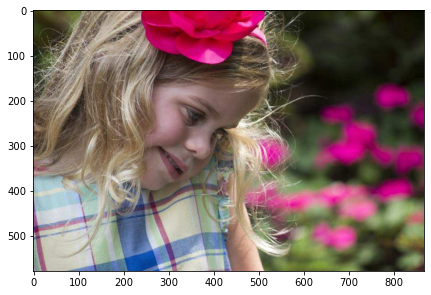

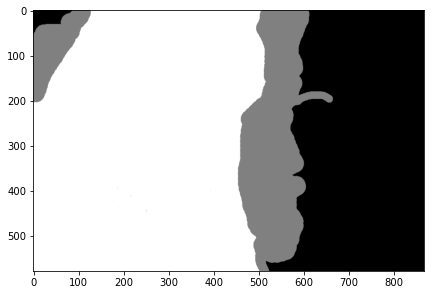

In [17]:
# Read guidance image
g = skio.imread('girl.png')/255
g = g[:,:,:3]
M,N,K=g.shape
print(g.shape)

# read image to be filtered
f = skio.imread('girl_map.png')/255
f = f[:,:,0]
M,N=f.shape
print(f.shape)

bg = skio.imread('background.jpg')/255
#bg = bg[:,:,:3]
M,N,K=bg.shape
print(bg.shape)


plt.close("all")

plt.figure(1, figsize=(7,7))
plt.imshow(g, cmap="gray")

plt.figure(2, figsize=(7,7))
plt.imshow(f, cmap="gray")

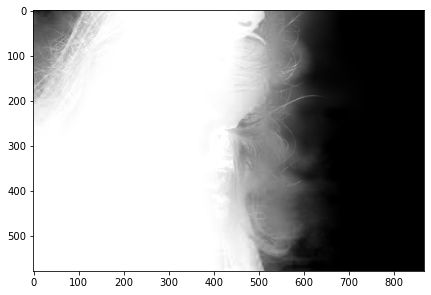

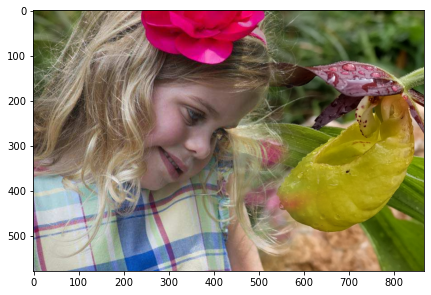

In [18]:
# epsilon
eps = 0.001

# filter radius
r = 50
ws = 2*r+1

# compute mean
m = uniform_filter(f, size=(ws, ws), mode='reflect')
mu = uniform_filter(g, size=(ws, ws, 1), mode='reflect')

# compute covariance
CV =  uniform_filter(g[:,:,None,:] * g[:,:,:,None],
                     size=(ws,ws,1,1), mode="reflect") - \
      mu[:,:,None,:] * mu[:,:,:,None]

CC =  uniform_filter(f[:,:,None] * g[:,:,:],
                     size=(ws,ws,1), mode="reflect") - \
      m[:,:,None] * mu[:,:,:]

# invert regualrized covariance
CV_inv = np.linalg.inv(CV.copy() + eps*np.identity(3)[None,None,:,:])

# compute coefficients of linear regression
A = np.einsum("ijkl,ijl->ijk", CV_inv, CC)

# compute coefficients of linear regression
b = m - np.einsum("ijk,ijk->ij", A, mu)

# average them
A_ = uniform_filter(A, size=(ws, ws, 1), mode="reflect")
b_ = uniform_filter(b, size=(ws, ws), mode="reflect")

# filtered image
u = np.einsum("ijk,ijk->ij", A_, g) + b_
u = np.clip(u, a_min=0, a_max=1)

plt.figure(2, figsize=(7,7))
plt.imshow(u, cmap="gray")

plt.figure(3, figsize=(7,7))
plt.imshow(u[:,:,None]*g + (1-u[:,:,None])*bg)
skio.imsave("girl_matting.png", np.uint8(u*255))